### 1. Decompress input data

In [1]:
%%bash
unzip catdog_data.zip

Archive:  catdog_data.zip
   creating: catdog_data/
   creating: catdog_data/train/
   creating: catdog_data/train/cats/
  inflating: catdog_data/train/cats/cat.0.jpg  
  inflating: catdog_data/train/cats/cat.1.jpg  
  inflating: catdog_data/train/cats/cat.2.jpg  
  inflating: catdog_data/train/cats/cat.3.jpg  
  inflating: catdog_data/train/cats/cat.4.jpg  
  inflating: catdog_data/train/cats/cat.5.jpg  
  inflating: catdog_data/train/cats/cat.6.jpg  
  inflating: catdog_data/train/cats/cat.7.jpg  
  inflating: catdog_data/train/cats/cat.8.jpg  
  inflating: catdog_data/train/cats/cat.9.jpg  
  inflating: catdog_data/train/cats/cat.10.jpg  
  inflating: catdog_data/train/cats/cat.11.jpg  
  inflating: catdog_data/train/cats/cat.12.jpg  
  inflating: catdog_data/train/cats/cat.13.jpg  
  inflating: catdog_data/train/cats/cat.14.jpg  
  inflating: catdog_data/train/cats/cat.15.jpg  
  inflating: catdog_data/train/cats/cat.16.jpg  
  inflating: catdog_data/train/cats/cat.17.jpg  
  infla

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### 2. Examine input images

In [12]:
%%bash
ls catdog_data/

test
train
validation


In [13]:
%%bash
ls catdog_data/train/*/*|wc -l
ls catdog_data/train/cats/*|wc -l
ls catdog_data/train/dogs/*|wc -l
ls catdog_data/test/*/*|wc -l
ls catdog_data/validation/*/*|wc -l

    2000
    1000
    1000
     400
     600


In [14]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import *
import utils
import os
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from matplotlib.image import imread
from keras.models import Sequential
from keras.layers import *
import typing
import cv2

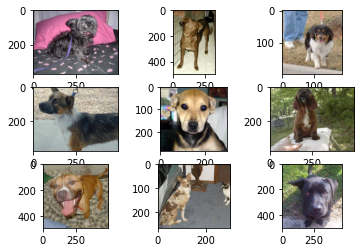

In [2]:
# plot dog photos from the dogs vs cats dataset
# define location of dataset
folder = 'catdog_data/train/dogs/'
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(3, 3, i+1)
    # define filename
    filename = f"{folder}dog.{str(i)}.jpg"
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

### 4. Pre-process and augment input images
Tutorial here: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

In [52]:
#Specifying the image
Image_Width=336
Image_Height=336
Batch_Size = 32
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [59]:
# randomly rotate the train images
rotation_generator = ImageDataGenerator(rescale=1./255, rotation_range=45, fill_mode='nearest')
brightness_generator = ImageDataGenerator(rescale=1./255, brightness_range = (0.5, 2.0))
hori_flip_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
vert_flip_generator = ImageDataGenerator(rescale=1./255, vertical_flip=True)
dual_flip_generator = ImageDataGenerator(rescale=1./255, vertical_flip=True, horizontal_flip=True)
zooming_generator = ImageDataGenerator(rescale=1./255, zoom_range=[0.667, 1.5]) # either zoom in or zoom out for up to 50%
shift_generator = ImageDataGenerator(rescale=1./255, width_shift_range=0.2, height_shift_range=0.2)
channel_shift_generator = ImageDataGenerator(rescale=1./255, channel_shift_range=60)
def blur(img):
    return (cv2.blur(img,(5,5)))
blurring_generator = ImageDataGenerator(rescale=1./255, preprocessing_function=blur)

aug_generators: tuple = (rotation_generator, brightness_generator, hori_flip_generator, vert_flip_generator, dual_flip_generator, zooming_generator, shift_generator, blurring_generator, channel_shift_generator)
aug_generator_names: tuple = ('rotation', 'brightness', 'horizontal_flip', 'vertical_flip', 'dual_flip', 'zooming', 'shift', 'blurring', 'channel_shift')

def obtain_dir_iterator_dict(img_data_generators: typing.Tuple[ImageDataGenerator], img_data_generator_names: typing.Tuple[str], train_img_path: str, Batch_size=32, Image_size: tuple=(256, 256)) -> typing.Dict[str, keras.preprocessing.image.DirectoryIterator]:
    assert len(img_data_generators)==len(img_data_generator_names), "The input tuples \"img_data_generators\" and \"img_data_generator_names\" must have the same length!"
    assert Batch_Size >= 16 and Batch_Size<=256, "Batch_size must be at least 16 and at most 256!"
    assert len(Image_Size)==2 and Image_Size[0]>0 and Image_Size[1]>0, "Image_size must be a tuple of two positive integers!"
    aug_img_gen_dict: typing.Dict[str, keras.preprocessing.image.DirectoryIterator] = {}
    for generator, generator_name in zip(img_data_generators, img_data_generator_names):
        aug_img_gen_dict[generator_name] = generator.flow_from_directory(batch_size=Batch_size, directory=train_img_path, target_size=Image_size, class_mode="binary")
    return aug_img_gen_dict

aug_img_flows_dict = obtain_dir_iterator_dict(aug_generators, aug_generator_names, "catdog_data/train", Batch_size=Batch_Size, Image_size=Image_Size)

# non-augmented original image data generators
original_generator = ImageDataGenerator(rescale=1./255)
ori_train_img_flow = original_generator.flow_from_directory(batch_size=Batch_Size, directory="catdog_data/train", target_size=Image_Size, class_mode="binary")
test_img_flow = original_generator.flow_from_directory(batch_size=Batch_Size, directory="catdog_data/test", target_size=Image_Size, class_mode="binary")
val_img_flow = original_generator.flow_from_directory(batch_size=Batch_Size, directory="catdog_data/validation/", target_size=Image_Size, class_mode="binary")
aug_img_flows_dict['original'] = ori_train_img_flow

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


### 5. Create a model using CNN model

In [ ]:
def create_CNN_Model(Image_size: tuple, Image_channels=3) -> keras.models.Sequential:
    assert len(Image_Size)==2 and Image_Size[0]>0 and Image_Size[1]>0, "Image_size must be a tuple of two positive integers!"
    model=Sequential()
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.15))
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.15))
    model.add(Conv2D(128,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.15))
    model.add(Conv2D(128,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.15))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(1,activation='sigmoid'))
    return model

model = create_CNN_Model(Image_size=Image_Size)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 334, 334, 32)      896       
                                                                 
 batch_normalization_60 (Bat  (None, 334, 334, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 167, 167, 32)     0         
 g2D)                                                            
                                                                 
 dropout_60 (Dropout)        (None, 167, 167, 32)      0         
                                                                 
 conv2d_49 (Conv2D)          (None, 165, 165, 64)      18496     
                                                                 
 batch_normalization_61 (Bat  (None, 165, 165, 64)   

In [76]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [77]:
def fitted_model(model: Sequential, lr: float, train_imgs: keras.preprocessing.image.DirectoryIterator, val_imgs: keras.preprocessing.image.DirectoryIterator) -> typing.Tuple:
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["accuracy"])
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='weights.best.inc.blond.hdf5', verbose=1, save_best_only=True)
    model_history = model.fit(train_imgs, 
                            validation_data=val_imgs,
                            steps_per_epoch=len(train_imgs),
                            validation_steps=len(val_imgs),
                            epochs=5, callbacks=[checkpointer])
    return (model, model_history)

### 5. Train different augmented datasets, thus saving, loading the model and test the accuracy using the test data set

In [ ]:
training_history: typing.List[tf.keras.callbacks.History] = []
aug_labels: typing.List[str] = list(aug_img_flows_dict.keys())

def obtain_lr(initial_lr: float, total_epochs: int, epoch_index: int) -> float:
    assert total_epochs>=2 and total_epochs%2==0, "The number of epochs must be an odd number that's >=2!"
    assert 0<=epoch_index<total_epochs, "The index of an epoch 'i' must suffice 0<=i<total_epochs!"
    return initial_lr if (epoch_index+1)<=total_epochs/2 else initial_lr/10

shuffled_img_flow: typing.List[keras.preprocessing.image.DirectoryIterator] = []
for _ in range(2):
    random.shuffle(aug_labels)
    shuffled_img_flow.extend([aug_img_flows_dict[label] for label in aug_labels])

for i, img_flow in enumerate(shuffled_img_flow):
    model, history = fitted_model(model, obtain_lr(1e-3, len(shuffled_img_flow)*5, i), img_flow, val_img_flow)
    training_history.append(history)
    model.save("dog_cat_adam_aug_CNN.h5")

Epoch 1/5
35/63 [===============>..............] - ETA: 13s - loss: 1.1604 - accuracy: 0.5833

KeyboardInterrupt: 

In [ ]:
%%bash
# grep validation accuracy using Perl-style regex
grep val_accuracy Project1.1.ipynb|gsed -r 's/\\n",$//'|ggrep -Po "(?<=val_accuracy:\s).+"

0.5050
0.5000
0.5000
0.5000
0.5117
0.5983
0.5917
0.6400
0.7017
0.6433
0.7033
0.6950
0.7133
0.6967
0.7567
0.7383
0.6883
0.7400
0.6600
0.7633
0.7383
0.6750
0.7417
0.7567
0.7517
0.7533
0.7067
0.7667
0.7400
0.7767
0.7267
0.7550
0.7350
0.6850
0.7833
0.7883
0.7983
0.7817
0.6833
0.7567
0.7733
0.7400
0.7700
0.7850
0.7967
0.7367
0.7800
0.7683
0.7917
0.8083
0.6567
0.8183
0.7317
0.8083
0.7083
0.7567
0.7700
0.6350
0.7217
0.7067
0.7333
0.7600
0.7733
0.7950
0.6567
0.7383
0.7850
0.7950
0.7450
0.7883
0.7633
0.7617
0.8167
0.7317
0.8067
0.7550
0.7767
0.7133
0.7567
0.7917
0.8183
0.7800
0.7617
0.7567
0.7333
0.7750
0.7550
0.8067
0.7883
0.7867
0.6950
0.8267
0.7267
0.7667
0.7550
0.8217
0.7300
0.8017
0.7433


### 6. Export the training and validation history into a json file via <code>json.dumps</code>

In [ ]:
from json import dumps # takes a n object and returns to a string

with open("CNN_training_history.json", "w") as f:
    f.write(dumps([el.history for el in training_history]))

### 7. Evaluate the accuracy of the trained model after 80 randomly shuffled epochs (5*2 epochs for each augmented data flow)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("dog_cat_adam_aug_CNN.h5")
acc = model.evaluate(test_img_flow, verbose=0)[1]
print(round(acc, 4)*100)

80.0


### 8. Aiming for further improvement using empty-weighted ResNet50 architecture

In [79]:
def create_ResNet50_Model(Image_size: tuple, Image_channels=3) -> keras.models.Sequential:
    assert len(Image_Size)==2 and Image_Size[0]>0 and Image_Size[1]>0, "Image_size must be a tuple of two positive integers!"
    model=Sequential()
    model.add(tf.keras.applications.resnet50.ResNet50(input_shape=Image_Size+(Image_channels, ), weights=None, pooling=max))
    model.add(Dense(1,activation='sigmoid'))
    return model

model = create_ResNet50_Model(Image_size=Image_Size)
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense_26 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 25,637,713
Trainable params: 25,584,593
Non-trainable params: 53,120
_________________________________________________________________


In [80]:
training_history: typing.List[tf.keras.callbacks.History] = []
aug_labels: typing.List[str] = list(aug_img_flows_dict.keys())

def obtain_lr(initial_lr: float, total_epochs: int, epoch_index: int) -> float:
    assert total_epochs>=2 and total_epochs%2==0, "The number of epochs must be an odd number that's >=2!"
    assert 0<=epoch_index<total_epochs, "The index of an epoch 'i' must suffice 0<=i<total_epochs!"
    return initial_lr if (epoch_index+1)<=total_epochs/2 else initial_lr/10

shuffled_img_flow: typing.List[keras.preprocessing.image.DirectoryIterator] = []
for _ in range(2):
    random.shuffle(aug_labels)
    shuffled_img_flow.extend([aug_img_flows_dict[label] for label in aug_labels])

for i, img_flow in enumerate(shuffled_img_flow):
    model, history = fitted_model(model, obtain_lr(1e-3, len(shuffled_img_flow)*5, i), img_flow, val_img_flow)
    training_history.append(history)
    model.save("dog_cat_adam_aug_ResNet.h5")

Epoch 1/5
63/63 [==============================] - ETA: 0s - loss: 0.6899 - accuracy: 0.5475
Epoch 1: val_loss improved from inf to 0.69370, saving model to weights.best.inc.blond.hdf5
63/63 [==============================] - 149s 2s/step - loss: 0.6899 - accuracy: 0.5475 - val_loss: 0.6937 - val_accuracy: 0.5050
Epoch 2/5
36/63 [================>.............] - ETA: 33s - loss: 0.6946 - accuracy: 0.4974

In [ ]:
with open("ResNet_training_history.json", "w") as f:
    f.write(dumps([el.history for el in training_history]))

model = load_model("dog_cat_adam_aug_ResNet.h5")
acc = model.evaluate(test_img_flow, verbose=0)[1]
print(round(acc, 4)*100)